<a href="https://colab.research.google.com/github/ollihansen90/Mathe-SH/blob/main/Schachcomputer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Schachcomputer


## Setup

In [1]:
!wget -qnc https://raw.githubusercontent.com/ollihansen90/Mathe-SH/refs/heads/main/utils/schach_utils.py
#!pip install chess python-lichess

## Teste Bewertungsfunktion

In [2]:
#global bauer
from schach_utils import Spielfeld, berechne_wert
leer = 0
bauer = 1

schachbrett = Spielfeld()
schachbrett.reset()
schachbrett["H7"] = leer
schachbrett["C2"] = leer
schachbrett["E2"] = leer
schachbrett["G2"] = leer
schachbrett["D2"] = leer
schachbrett["D4"] = bauer
schachbrett["F3"] = bauer
schachbrett.male()
print(berechne_wert(schachbrett))
schachbrett.male()

♜♞♝♛♚♝♞♜
♟♟♟♟♟♟♟♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♘♖

3.0
♜♞♝♛♚♝♞♜
♟♟♟♟♟♟♟♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♘♖



## KI-Gegner
- Zufälliger Zug
- Zufälliger Zug mit guten Zügen wahrscheinlicher
- Greedy-Zug (nimm immer den besten)
- Minimax mit Tiefe 2
- Minimax mit beliebiger Tiefe

### Todo:
- Alpha-Beta-Pruning

In [30]:
from typing import Counter
import copy
from random import randint
from schach_utils import get_alle_bewegungen, zug
import time
global counter
counter = 0

def argsort(l):
    liste = l[:]
    output = []
    kleinster_wert = -float("inf")
    for _ in range(len(liste)):
        kleinster = float("inf")
        kleinstes_i = 0
        for i in range(len(liste)):
            if liste[i]<kleinster and liste[i]>=kleinster_wert:
                #print(liste[i], kleinster)
                kleinster = liste[i]
                kleinstes_i = i
        kleinster_wert = kleinster
        output.append(kleinstes_i)
        liste[kleinstes_i] = float("inf")
    return output

def waehle_zufall(scores):
    scores = [(eintrag-min(scores)+1)**2 for eintrag in scores]
    z = randint(0,int(2*sum(scores)))
    for i in range(len(scores)):
        eintrag = scores[i]
        z -= 2*eintrag
        if z<1:
            return i

def ki_zug(schachbrett):
    # zufälliger Greedy-Zug
    zuege = get_alle_bewegungen(schachbrett)
    hilfsbrett = Spielfeld()
    werte = []
    for z in zuege:
        hilfsbrett.feld = copy.deepcopy(schachbrett.feld)
        zug(hilfsbrett, z)
        werte.append(berechne_wert(hilfsbrett))
    zuege = [zuege[i] for i in argsort(werte)][::-1]
    next_zug = zuege[waehle_zufall(sorted(werte, reverse=True)[:len(werte)//3])]
    return next_zug

def ki_zug_det(schachbrett):
    # Greedy-Zug
    zuege = get_alle_bewegungen(schachbrett)
    hilfsbrett = Spielfeld()
    werte = []
    for z in zuege:
        hilfsbrett.feld = copy.deepcopy(schachbrett.feld)
        zug(hilfsbrett, z)
        werte.append(berechne_wert(hilfsbrett))
    zuege = [zuege[i] for i in argsort(werte)][::-1]
    next_zug = zuege[0]
    return next_zug

def ki_minimax(schachbrett):
    # Einfacher Minimax-Zug mit einem Schritt in die Zukunft
    zuege = get_alle_bewegungen(schachbrett)
    hilfsbrett = Spielfeld()
    werte = []
    for z in zuege:
        #print(z, end=" ")
        hilfsbrett.feld = copy.deepcopy(schachbrett.feld)
        zug(hilfsbrett, z) # KI-Zug (Schritt 1)
        hilfsbrett.invertiere()
        zug(hilfsbrett, ki_zug_det(hilfsbrett)) # Spieler-Antwort (Schritt 2)
        hilfsbrett.invertiere()
        wert = berechne_wert(hilfsbrett)
        werte.append(wert)
    zuege = [zuege[i] for i in argsort(werte)][::-1]
    next_zug = zuege[0]
    return next_zug

def ki_minimax_rek(schachbrett, tiefe=0, max_tiefe=3):
    # Minimax mit beliebiger Tiefe (dauert dann nur lange)
    if tiefe==max_tiefe:
        global counter
        counter += 1
        return ki_zug_det(schachbrett)
    zuege = get_alle_bewegungen(schachbrett)
    hilfsbrett = Spielfeld()
    werte = []

    for z in zuege:
        hilfsbrett.feld = copy.deepcopy(schachbrett.feld)
        #print(z, berechne_wert(hilfsbrett))
        zug(hilfsbrett, z)
        hilfsbrett.invertiere()
        zug(hilfsbrett, ki_minimax_rek(hilfsbrett, tiefe=tiefe+1, max_tiefe=max_tiefe))
        hilfsbrett.invertiere()
        wert = berechne_wert(hilfsbrett)
        werte.append(wert)
    zuege = [zuege[i] for i in argsort(werte)][::-1]
    next_zug = zuege[0]
    return next_zug

def ki(schachbrett, max_tiefe, maxi):
    zuege = get_alle_bewegungen(schachbrett)
    werte = []

    hilfsbrett = Spielfeld()
    for z in zuege:
        hilfsbrett.feld = copy.deepcopy(schachbrett.feld)
        zug(hilfsbrett, z)

        wert = alphabeta(hilfsbrett, tiefe=1, max_tiefe=max_tiefe, maxi=maxi)
        werte.append(wert)

    zuege = [zuege[i] for i in argsort(werte)][::-1]
    next_zug = zuege[0]
    return next_zug

def alphabeta(schachbrett, tiefe=0, max_tiefe=3, alpha=-float("inf"), beta=float("inf"), maxi=True):
    if tiefe==max_tiefe:
        global counter
        counter += 1
        hilfsbrett = Spielfeld()
        hilfsbrett.feld = copy.deepcopy(schachbrett.feld)
        if not maxi:
            for zeile in range(8):
                for s in range(8):
                    hilfsbrett.feld[zeile][s] = -1*hilfsbrett.feld[zeile][s]
        return berechne_wert(hilfsbrett)

    zuege = get_alle_bewegungen(schachbrett)
    hilfsbrett = Spielfeld()

    if maxi:
        for z in zuege:
            hilfsbrett.feld = copy.deepcopy(schachbrett.feld)
            zug(hilfsbrett, z)
            hilfsbrett.invertiere()
            wert = alphabeta(hilfsbrett, tiefe=tiefe+1, max_tiefe=max_tiefe, alpha=alpha, beta=beta, maxi=False)
            if wert <= beta:
                beta = wert
            if beta <= alpha:
                return beta
        return beta
    else:
        for z in zuege:
            hilfsbrett.feld = copy.deepcopy(schachbrett.feld)
            zug(hilfsbrett, z)
            hilfsbrett.invertiere()
            wert = alphabeta(hilfsbrett, tiefe=tiefe+1, max_tiefe=max_tiefe, alpha=alpha, beta=beta, maxi=True)
            if wert <= alpha:
                alpha = wert
            if beta <= alpha:
                return alpha
        return alpha

def minimax_alphabeta(baum, alpha=-float("inf"), beta=float("inf"), maxi=True):
    if isinstance(baum, int):
        return baum
    elif len(baum)==1:
        return baum[0]

    if maxi==True:
        # Checke linken Arm
        for arm in baum:
            wert = minimax_alphabeta(arm, alpha, beta, maxi=False)
            if wert >= alpha:
                alpha = wert
            if beta <= alpha:
                return alpha
        return alpha
    else:
        for arm in baum:
            wert = minimax_alphabeta(arm, alpha, beta, maxi=True)
            if wert <= beta:
                beta = wert
            if beta <= alpha:
                return beta
        return beta


def ki_alphabeta(schachbrett, tiefe=0, max_tiefe=3, alpha=-float("inf"), beta=float("inf"), maxi=True):
    if tiefe==max_tiefe:
        global counter
        counter += 1
        return ki_zug_det(schachbrett)
    zuege = get_alle_bewegungen(schachbrett)
    hilfsbrett = Spielfeld()
    werte = []

    for z in zuege:
        hilfsbrett.feld = copy.deepcopy(schachbrett.feld)
        zug(hilfsbrett, z)
        hilfsbrett.invertiere()
        if not maxi:
            zug(hilfsbrett, ki_alphabeta(hilfsbrett, tiefe=tiefe+1, max_tiefe=max_tiefe, alpha=alpha, beta=beta, maxi=False))
            hilfsbrett.invertiere()
            wert = berechne_wert(hilfsbrett)
            if wert >= alpha:
                alpha = wert
            if beta <= alpha:
                return z
            werte.append(wert)
        else:
            zug(hilfsbrett, ki_alphabeta(hilfsbrett, tiefe=tiefe+1, max_tiefe=max_tiefe, alpha=alpha, beta=beta, maxi=True))
            hilfsbrett.invertiere()
            #hilfsbrett.male()
            for zeile in range(8):
                for s in range(8):
                    hilfsbrett.feld[zeile][s] = -1*hilfsbrett.feld[zeile][s]
            #hilfsbrett.male()
            #return
            wert = berechne_wert(hilfsbrett)
            for zeile in range(8):
                for s in range(8):
                    hilfsbrett.feld[zeile][s] = -1*hilfsbrett.feld[zeile][s]
            if wert <= beta:
                beta = wert
            if beta <= alpha:
                return z
            werte.append(wert)
    #print(werte)
    zuege = [zuege[i] for i in argsort(werte)][::-1]
    next_zug = zuege[0]
    return next_zug


schachbrett = Spielfeld()
schachbrett.reset()
schachbrett.male()
start = time.time()
z = 0#ki_minimax_rek(schachbrett, max_tiefe=3)
print(z)
print(counter)
print(time.time()-start)
start = time.time()
z = ki(schachbrett, max_tiefe=5, maxi=True)
print(z)
print(counter)
print(time.time()-start)
zug(schachbrett, z)
schachbrett.male()
berechne_wert(schachbrett)

♜♞♝♛♚♝♞♜
♟♟♟♟♟♟♟♟
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♘♖

0
0
0.00012683868408203125
Nf3
8356
5.3741583824157715
♜♞♝♛♚♝♞♜
♟♟♟♟♟♟♟♟
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♘♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♙♖



1.0

## Spiel

In [ ]:
# Spiel spielen

from schach_utils import koenig
from time import sleep

schachbrett = Spielfeld()
schachbrett.reset()
schachbrett.feld[0] = [0,0,0,0,0,0,0,0]
schachbrett.feld[1] = [0,0,1,0,0,0,-1,0]
schachbrett.feld[3] = [0,0,0,0,0,-6,0,-1]
schachbrett.feld[4] = [4,0,0,0,0,0,0,0]
schachbrett.feld[6] = [1,1,0,0,0,0,1,1]
schachbrett.feld[7] = [4,2,3,0,0,0,6,0]
schachbrett.reset()
schachbrett.male()

while True:
    # Zug Weiß
    print(get_alle_bewegungen(schachbrett))
    print(berechne_wert(schachbrett))
    sleep(0.1)
    z = input("Weiß gibt einen Zug ein: ")
    while True:
        if zug(schachbrett, z) == None:
            break
        sleep(0.1)
        z = input("Weiß gibt einen Zug ein: ")
    schachbrett.male()

    # Zug Schwarz
    schachbrett.invertiere()
    if False:
        sleep(0.1)
        z = input("Schwarz gibt einen Zug ein: ")
        z = flip_pos(z)
        while True:
            if zug(schachbrett, z) == None:
                break
            sleep(0.1)
            z = input("Schwarz gibt einen Zug ein: ")
            z = flip_pos(z)

    counter = 0
    start = time.time()
    z = ki_minimax_rek(schachbrett, max_tiefe=3)
    #z = ki_alphabeta(schachbrett, max_tiefe=2, maxi=False)
    print(z, counter, time.time()-start)
    counter = 0
    start = time.time()
    #z = ki_minimax_rek(schachbrett, max_tiefe=2)
    z = ki_alphabeta(schachbrett, max_tiefe=3, maxi=False)
    print(z, counter, time.time()-start)
    zug(schachbrett, z)
    schachbrett.invertiere()
    schachbrett.male()

    # König weg?
    schwarzer_koenig = False
    weisser_koenig = False
    for i in range(8):
        for j in range(8):
            if abs(schachbrett.feld[i][j])==koenig:
                if schachbrett.feld[i][j]>0:
                    weisser_koenig = True
                else:
                    schwarzer_koenig = True
    if weisser_koenig and not schwarzer_koenig:
        print("Weiß hat gewonnen!")
        break
    elif schwarzer_koenig and not weisser_koenig:
        print("Schwarz hat gewonnen!")
        break


♜♞♝♛♚♝♞♜
♟♟♟♟♟♟♟♟
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♘♖

['a3', 'a4', 'b3', 'b4', 'c3', 'c4', 'd3', 'd4', 'e3', 'e4', 'f3', 'f4', 'g3', 'g4', 'h3', 'h4', 'Nc3', 'Na3', 'Nh3', 'Nf3']
0.0
Weiß gibt einen Zug ein: e4
♜♞♝♛♚♝♞♜
♟♟♟♟♟♟♟♟
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♘♖

d4 13308 133.02400398254395
d4 13308 133.54419565200806
♜♞♝♛♚♝♞♜
♟♟♟♙♟♟♟♟
♙♙♙♙♙♙♙♙
♙♙♙♟♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♘♖

['e5', 'd5', 'a3', 'a4', 'b3', 'b4', 'c3', 'c4', 'd3', 'd4', 'f3', 'f4', 'g3', 'g4', 'h3', 'h4', 'Nc3', 'Na3', 'Qe2', 'Qf3', 'Qg4', 'Qh5', 'Ke2', 'Be2', 'Bd3', 'Bc4', 'Bb5', 'Ba6', 'Nh3', 'Nf3', 'Ne2']
1.0


KeyboardInterrupt: Interrupted by user

## Installiere Stockfish

In [ ]:
# Lade und installiere Stockfish

!wget https://github.com/official-stockfish/Stockfish/releases/latest/download/stockfish-ubuntu-x86-64-avx2.tar
!tar xvf stockfish-ubuntu-x86-64-avx2.tar -C .

--2025-06-11 14:53:45--  https://github.com/official-stockfish/Stockfish/releases/latest/download/stockfish-ubuntu-x86-64-avx2.tar
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/official-stockfish/Stockfish/releases/download/sf_17.1/stockfish-ubuntu-x86-64-avx2.tar [following]
--2025-06-11 14:53:46--  https://github.com/official-stockfish/Stockfish/releases/download/sf_17.1/stockfish-ubuntu-x86-64-avx2.tar
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/20976138/85758419-9488-4267-84ea-dc1379a61eb1?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=releaseassetproduction%2F20250611%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20250611T145346Z&X-Amz-Expires=300&X-Amz-Signature=00e6219256ec4ab6d343c780fc19cd

## FEN (Forsyth–Edwards Notation)

♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♟♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♚♙♟
♖♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♖♘♗♙♙♙♔♙

[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, -1, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, -6, 0, -1]
[4, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 1, 1]
[4, 2, 3, 0, 0, 0, 6, 0]
8/2P3p1/8/5k1p/R7/8/PP4PP/RNB3K1
c1g5
d7d5
h2h4
b8c6
b1c3
d8d7
f1b5
e7e6
h4h5
f7f6
g5e3
d7f7
b5d3
g8e7
g1e2
h8h5


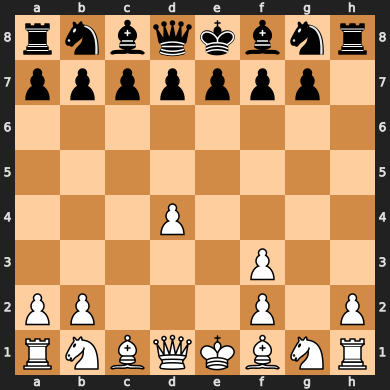

In [ ]:
# Algorithmus zum Umwandeln von unserer Brett-Notation zu FEN

import chess.engine
engine = chess.engine.SimpleEngine.popen_uci("/content/stockfish/stockfish-ubuntu-x86-64-avx2")

board = chess.Board("r1bqkbnr/p1pp1ppp/1pn5/4p3/2B1P3/5Q2/PPPP1PPP/RNB1K1NR w KQkq - 2 4")
board = chess.Board("rnbqkbnr/ppppppp1/8/8/3P4/5P2/PP3P1P/RNBQKBNR w Kkq - 2 4")

def brett_to_string(brett):
    output = ""
    figuren = "0PNBRQKkqrbnp"
    nullen = 0
    for zeile in brett:
        for feld in zeile:
            if feld==0:
                nullen+=1
            elif nullen>0:
                output += str(nullen)
                output += figuren[feld]
                nullen = 0
            else:
                output += figuren[feld]
        if nullen>0:
            output += str(nullen)
            nullen = 0
        output += "/"
    return output[:-1]

schachbrett.male()
for zeile in schachbrett.feld:
    print(zeile)
print(brett_to_string(schachbrett.feld))
info = engine.analyse(board, chess.engine.Limit(depth=20))
print(*info["pv"], sep="\n")
board

## Spiel gegen Stockfish

In [ ]:
# Lade Stockfish und nutze als "Gehirn"

from schach_utils import koenig
engine = chess.engine.SimpleEngine.popen_uci("/content/stockfish/stockfish-ubuntu-x86-64-avx2")

schachbrett = Spielfeld()
schachbrett.male()

def ki_zug_stockfish(schachbrett, zug=0):
    schachbrett.invertiere()
    figurenzuordnung = ["", "", "N", "B", "R", "Q", "K"]
    fen_brett = brett_to_string(schachbrett.feld) # "rnbqkbnr/ppppppp1/8/8/3P4/5P2/PP3P1P/RNBQKBNR w Kkq - 2 4"
    fen_brett += " b - - 0 "+str(zug)
    board = chess.Board(fen_brett)
    info = engine.analyse(board, chess.engine.Limit(depth=20))
    zug = str(info["pv"][0])
    von = zug[:2]
    bis = zug[2:]
    zug = figurenzuordnung[abs(schachbrett[von])]+bis
    zug = zug[:-1]+str(9-int(zug[-1]))
    schachbrett.invertiere()
    return zug

num_zug = 1
while True:
    # Zug Weiß
    print(get_alle_bewegungen(schachbrett))
    print(berechne_wert(schachbrett))
    z = input("Weiß gibt einen Zug ein: ")
    while True:
        if zug(schachbrett, z) == None:
            break
        z = input("Weiß gibt einen Zug ein: ")
    schachbrett.male()

    # Zug Schwarz
    schachbrett.invertiere()
    z = ki_zug_stockfish(schachbrett, num_zug)
    zug(schachbrett, z)
    schachbrett.invertiere()
    schachbrett.male()

    # König weg?
    schwarzer_koenig = False
    weisser_koenig = False
    for i in range(8):
        for j in range(8):
            if abs(schachbrett.feld[i][j])==koenig:
                if schachbrett.feld[i][j]>0:
                    weisser_koenig = True
                else:
                    schwarzer_koenig = True
    if weisser_koenig and not schwarzer_koenig:
        print("Weiß hat gewonnen!")
        break
    elif schwarzer_koenig and not weisser_koenig:
        print("Schwarz hat gewonnen!")
        break

    num_zug += 1


♜♞♝♛♚♝♞♜
♟♟♟♟♟♟♟♟
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♘♖

['a3', 'a4', 'b3', 'b4', 'c3', 'c4', 'd3', 'd4', 'e3', 'e4', 'f3', 'f4', 'g3', 'g4', 'h3', 'h4', 'Nc3', 'Na3', 'Nh3', 'Nf3']
0.0
Weiß gibt einen Zug ein: e4
♜♞♝♛♚♝♞♜
♟♟♟♟♟♟♟♟
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♘♖

♜♞♝♛♚♝♞♜
♟♟♙♟♟♟♟♟
♙♙♙♙♙♙♙♙
♙♙♟♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♘♖

['e5', 'a3', 'a4', 'b3', 'b4', 'c3', 'c4', 'd3', 'd4', 'f3', 'f4', 'g3', 'g4', 'h3', 'h4', 'Nc3', 'Na3', 'Qe2', 'Qf3', 'Qg4', 'Qh5', 'Ke2', 'Be2', 'Bd3', 'Bc4', 'Bb5', 'Ba6', 'Nh3', 'Nf3', 'Ne2']
4.0
Weiß gibt einen Zug ein: Nf3
♜♞♝♛♚♝♞♜
♟♟♙♟♟♟♟♟
♙♙♙♙♙♙♙♙
♙♙♟♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♘♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♙♖

♜♙♝♛♚♝♞♜
♟♟♙♟♟♟♟♟
♙♙♞♙♙♙♙♙
♙♙♟♙♙♙♙♙
♙♙♙♙♙♙♙♙
♙♙♙♙♙♘♙♙
♙♙♙♙♙♙♙♙
♖♘♗♕♔♗♙♖

['e5', 'Ng5', 'Ne5', 'Nh4', 'Ng1', 'Nd4', 'a3', 'a4', 'b3', 'b4', 'c3', 'c4', 'd3', 'd4', 'g3', 'g4', 'h3', 'h4', 'Nc3', 'Na3', 'Qe2', 'Ke2', 'Be2', 'Bd3', 'Bc4', 'Bb5', 'Ba6', 'Rg1']
1.0


KeyboardInterrupt: Interrupted by user

# Archiv

In [ ]:
!wget https://raw.githubusercontent.com/prateeksan/chesspi/development/sample_data/Kasparov.pgn -O "Kasparov.txt"

In [ ]:
with open("Kasparov.txt", "rb") as file:
    zeilen = file.readlines()


In [ ]:
spiele = ("\n".join([z.decode('ascii').strip() for z in zeilen[:34000]])).split("\n\n")[1::2]
print(len(spiele))


In [ ]:
spielliste = []

for spiel in spiele:
    spiel = spiel.replace("\n", " ")
    spiel_ohne_ergebnis = spiel.split("  ")[0]+"  "
    zugliste = [z.split(" ")[:2] for z in spiel_ohne_ergebnis.split(".")[1:]]
    spielliste.append(zugliste)

In [ ]:
print(*spielliste[0], sep="\n")